In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import spatial
import os
import merge_bubbles_3d_v2 as merge
from matplotlib.colors import hsv_to_rgb
import advect_bubbles_3D_eval_v14 as adv
import pickle




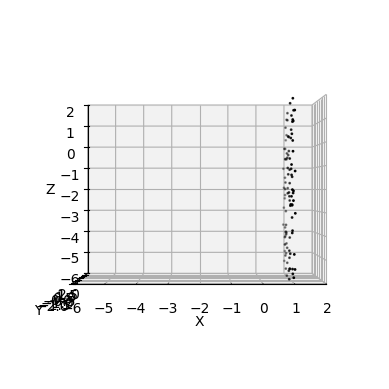

In [4]:
N_realisation = 3
np.random.seed(N_realisation) 

# FOR actual simulation
# N0_particle = V_gas / (4/3 * np.pi * a_0 **3)  # Number of particles in the domain
N0_particle = 100

# line plume thickness
plume_w = 0.1

XP0 = np.random.uniform((1-plume_w/2), (1+plume_w/2), N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
ZP0 = np.random.uniform(-6, 2, N0_particle)

St0 = 0.5
R_collision = 0.02
Fr = 0.5

xl, xr = -6, 2
yl, yr = -2, 2
zd, zu = -6, 2

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 8, 4, 8
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=270)

ax.scatter(XP0, YP0, ZP0,s=1, c='k', marker='o')
ax.set_xlim(-6, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-6, 2)


plt.show()

In [5]:
Bubbles_df_ini = np.zeros((N0_particle, 17), dtype=np.float64)

# first column is bubbles ID
Bubbles_df_ini[:, 0] = np.arange(N0_particle)

# second column is bubbles X position
Bubbles_df_ini[:, 1] = XP0.flatten().astype(float)

# third column is bubbles Y position   
Bubbles_df_ini[:, 2] = YP0.flatten().astype(float)

# fourth column is bubbles Z position
Bubbles_df_ini[:, 3] = ZP0.flatten().astype(float)

# fourth column is bubbles x-velocity
Bubbles_df_ini[:, 4] = np.zeros(N0_particle)

# fifth column is bubbles y-velocity
Bubbles_df_ini[:, 5] = np.zeros(N0_particle)

# sixth column is bubbles z-velocity
Bubbles_df_ini[:, 6] = np.zeros(N0_particle)

# sixth column is bubbles Stokes number
Bubbles_df_ini[:, 7] = St0

# seventh column is bubbles slaved status
Bubbles_df_ini[:, 8] = False

# eighth column is bubbles gridA x-index
Bubbles_df_ini[:, 9] = np.floor((Bubbles_df_ini[:, 1] - xl ) / dx_col).astype(int)

# ninth column is bubbles gridA y-index
Bubbles_df_ini[:, 10] = np.floor((Bubbles_df_ini[:, 2] - yl ) / dy_col).astype(int)

# tenth column is bubbles gridA z-index
Bubbles_df_ini[:, 11] = np.floor((Bubbles_df_ini[:, 3] - zd ) / dz_col).astype(int)

# tenth column is bubbles gridB x-index
Bubbles_df_ini[:, 12] = np.floor((Bubbles_df_ini[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

# eleventh column is bubbles gridB y-index	
Bubbles_df_ini[:, 13] = np.floor((Bubbles_df_ini[:, 2]- yl + dy_col / 2) / dy_col).astype(int)

# twelfth column is bubbles gridB z-index
Bubbles_df_ini[:, 14] = np.floor((Bubbles_df_ini[:, 3]- zd + dz_col / 2) / dz_col).astype(int)

# the last column tracks if fraction of bubbles have visited the core (upper)
Bubbles_df_ini[:, 15] = np.zeros(N0_particle)

# the last column tracks if fraction of bubbles have visited the core (lower)
Bubbles_df_ini[:, 16] = np.zeros(N0_particle)

# ditch the ones about to leave the domain 
Bubbles_df_ini = Bubbles_df_ini[(Bubbles_df_ini[:, 1] >= xl) & (Bubbles_df_ini[:, 1] < xr) 
                                & (Bubbles_df_ini[:, 2] >= yl) & (Bubbles_df_ini[:, 2] < yr)
                                & (Bubbles_df_ini[:, 3] >= zd) & (Bubbles_df_ini[:, 3] < zu)]

In [ ]:
# from matplotlib.path import Path
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# x_2d = Bubbles_df_ini[:, 1]
# y_2d = np.sqrt(Bubbles_df_ini[:, 2]**2 + Bubbles_df_ini[:, 3]**2) * np.sign(Bubbles_df_ini[:, 3])

# path = 'velocity_fields/alpha_0.4_2D/'


# geometry_2D = np.load(path + 'geometry.npy')

# x_core_2d, y_core_2d, y_core_lower_2d, _, _ = geometry_2D.T

# inside_upper_core = Path(np.array([x_core_2d, y_core_2d]).T).contains_points(np.array([x_2d, y_2d]).T)
# inside_lower_core = Path(np.array([x_core_2d, y_core_lower_2d]).T).contains_points(np.array([x_2d, y_2d]).T)

# ax.scatter(x_core_2d, y_core_2d, np.zeros(len(x_core_2d)), s=1)
# ax.scatter(x_core_2d, y_core_lower_2d, np.zeros(len(x_core_2d)), s=1)

# ax.scatter(Bubbles_df_ini[:, 1], Bubbles_df_ini[:, 2], Bubbles_df_ini[:, 3], s=1, c='k')
# ax.scatter(Bubbles_df_ini[inside_upper_core, 1], Bubbles_df_ini[inside_upper_core, 2], Bubbles_df_ini[inside_upper_core, 3], s=10, c='r', marker='x')
# ax.scatter(Bubbles_df_ini[inside_lower_core, 1], Bubbles_df_ini[inside_lower_core, 2], Bubbles_df_ini[inside_lower_core, 3], s=10, c='b', marker='x')
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_zlim(-2, 2)
# ax.view_init(elev=0, azim=0)

In [6]:
from matplotlib.path import Path
path = 'velocity_fields/alpha_0.8_2D/'


geometry_2D = np.load(path + 'geometry.npy')

x_core_2d, y_core_2d, y_core_lower_2d, _, _ = geometry_2D.T

def mark_inRing(before_adv_df):
    '''
    # UPDATE inRing status of bubbles after advection
    after_adv_df : (n_bubble, 3), (x, y, z)-positions of bubbles after advection
    '''
    x_2d = before_adv_df[:, 1]
    y_2d = np.sqrt(before_adv_df[:, 2]**2 + before_adv_df[:, 3]**2) * np.sign(before_adv_df[:, 3])
    inside_upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    inside_lower_core = Path(np.vstack([x_core_2d, y_core_lower_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    before_adv_df[inside_upper_core, 15] = 1
    before_adv_df[inside_lower_core, 16] = 1

    return None

# mark_inRing(Bubbles_df_ini)

In [7]:

def record_deposit_bubbles(current_time, before_df, after_adv_states, deposit_dict, ceiling_height: float, incore_thresh: float =0):
    '''
    before_df : (n_bubble, 16) np.array, the last column tracks volume fraction of the bubble that has been in the core
    after_df : (n_bubble, 3), (x, y, z)-positions of bubbles after advection
    modify deposit_dict in-place
    '''

    # filter out the bubbles that have been in the core
    # filter out bubbles that deposit 
    temp = after_adv_states.copy()
    filtered_before_df = before_df[((before_df[:, 15] >= incore_thresh) | (before_df[:, 16] >= incore_thresh)) & (temp[:, 2] >= ceiling_height), :]
    
    if filtered_before_df.shape[0] == 0:
        deposit_dict[current_time] = None
        return None

    else:
        temp = temp[((before_df[:, 15] >= incore_thresh) | (before_df[:, 16] >= incore_thresh)) & (temp[:, 2] > ceiling_height), :]

        # linear interpolate to find the x, y-location of the deposited bubbles
        dep_x_location = (filtered_before_df[:, 1] * (temp[:, 2] - ceiling_height) + temp[:, 0] * (ceiling_height - filtered_before_df[:, 3])) / (temp[:, 2] - filtered_before_df[:, 3])
        dep_y_location = (filtered_before_df[:, 2] * (temp[:, 2] - ceiling_height) + temp[:, 1] * (ceiling_height - filtered_before_df[:, 3])) / (temp[:, 2] - filtered_before_df[:, 3])
        dep_z_location = temp[:, 2]
        deposit_dict[current_time] = np.hstack((filtered_before_df[:, 0], dep_x_location, dep_y_location, dep_z_location,  filtered_before_df[:, 7], filtered_before_df[:, 15], filtered_before_df[:, 16]))

        return None

# test_before_df = np.hstack((Bubbles_df_to_adv, np.random.uniform(0, 1, (Bubbles_df_to_adv.shape[0], 1))))



In [ ]:
# after_adv_states = updated_states
# before_df = Bubbles_df_to_adv
# incore_thresh = 0
# ceiling_height = 2
# current_time = 4
# temp = after_adv_states.copy()
# filtered_before_df = before_df[((before_df[:, 15] >= incore_thresh) | (before_df[:, 16] >= incore_thresh)) & (temp[:, 2] >= ceiling_height), :]
# temp = temp[((before_df[:, 15] >= incore_thresh) | (before_df[:, 16] >= incore_thresh)) & (temp[:, 2] > ceiling_height), :]

# dep_x_location = (filtered_before_df[:, 1] * (temp[:, 2] - ceiling_height) + temp[:, 0] * (ceiling_height - filtered_before_df[:, 3])) / (temp[:, 2] - filtered_before_df[:, 3])
# dep_y_location = (filtered_before_df[:, 2] * (temp[:, 2] - ceiling_height) + temp[:, 1] * (ceiling_height - filtered_before_df[:, 3])) / (temp[:, 2] - filtered_before_df[:, 3])
# dep_z_location = temp[:, 2]
# deposit_dict[current_time] = np.hstack((filtered_before_df[:, 0], dep_x_location, dep_y_location, dep_z_location,  filtered_before_df[:, 7], filtered_before_df[:, 15], filtered_before_df[:, 16]))

In [ ]:
tNow = 0
dt = 0.03
tEnd = 6
st_lim = 7
R_bounce = R_collision

N_tot = int((tEnd - tNow) / dt + 1)
N_mergeCycle = np.zeros(2, dtype=int)
# N_feedCycle = N_tot * np.ones(2, dtype=int)
# Nbub_already_supplemented = np.zeros(2)

# W_rising = St0_pool / (Fr**2)  # normalized by U_f
# flux_from_pool = N0_particle_pool * W_rising / (zd - z_far)  # normalized by 1/t_f
# N_in_from_pool = flux_from_pool * dt  # number of bubbles injected from the pool per time step

Bubbles_df_after_merge = Bubbles_df_ini.copy()
# Res_df_ini = Res_df_ini_0.copy()
# Pool_df_ini = Pool_df_ini_0.copy()
# Pool_df_ini[:, 6] = W_rising

V, H = np.mgrid[0:1:301j, 0:1:301j]
colors_hsv = np.dstack((H, np.ones_like(H), V))
colors_rgb = hsv_to_rgb(colors_hsv)

fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')

collision_series = []
masters_slaves_series = []
# influx_series = []
deposit_dict = {}
folder_path = 'lineplume_sims_3D/temp'

while tNow < tEnd:

    
    Bubbles_df_to_adv = Bubbles_df_after_merge.copy()
    # mark inRing status
    mark_inRing(Bubbles_df_to_adv)

    # updated_states = np.asarray(pab3d.main(initial_states=Bubbles_df_to_adv[:, 1:8], t0=tNow, tf=tNow+dt), dtype=np.float64).T
    updated_states = adv.advect_bubbles(Bubbles_df_to_adv, t0=tNow, tf=tNow+dt,plot_path=False, this_ax=None)

    # update deposited bubbles
    record_deposit_bubbles(tNow, Bubbles_df_to_adv, updated_states[:, :3], deposit_dict, ceiling_height=2)

    Bubbles_df_before_merge = Bubbles_df_to_adv.copy()

    Bubbles_df_after_merge, collision_list, masters_slaves_list = merge.merge_package(Bubbles_df_before_merge=Bubbles_df_to_adv, advected_states=updated_states, 
                                            gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape, boundaries=(xl, xr, yl, yr, zd, zu), cell_size=(dx_col, dy_col, dz_col),
                                            R_collision=R_collision, st_lim=st_lim, R_bounce=R_bounce, stick_bool=False, bounce_bool=True,
                                            merge_method='volume-weighted', timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle[0], N_mergeCycle[0], :])

    collision_series.append(collision_list)
    if len(masters_slaves_list) > 0:
        masters_slaves_series.append(masters_slaves_list)
    else:
        masters_slaves_series.append(None)
    tNow += dt
    N_mergeCycle += 1

    plt.savefig(folder_path + '/frame_{}.png'.format(N_mergeCycle[0]), dpi=300)
    np.save(os.path.join(folder_path, 'frame_{}.npy'.format(N_mergeCycle[0])), Bubbles_df_after_merge[:, 0:8])
    # plt.show()
    plt.close()




/home/zhizhi/plume_norburyRings/merge_bubbles_3d_v2.py:309: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
Process ForkPoolWorker-557:
Process ForkPoolWorker-560:
Process ForkPoolWorker-558:
Exception ignored in: <function _releaseLock at 0x7f656c298540>
Traceback (most recent call last):
  File "/home/zhizhi/.pyenv/versions/3.11.9/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Process ForkPoolWorker-556:
Process ForkPoolWorker-559:
Process ForkPoolWorker-553:
Process ForkPoolWorker-555:
Process ForkPoolWorker-554:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent

In [ ]:
file_path = os.path.join(folder_path, 'collision_series.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(collision_series, f)

with open(os.path.join(folder_path, 'masters_slaves_series.pkl'), 'wb') as f:
    pickle.dump(masters_slaves_series, f)

# with open(os.path.join(folder_path, 'influx_series.pkl'), 'wb') as f:
#     pickle.dump(influx_series, f)

with open(os.path.join(folder_path, 'deposit_dict.pkl'), 'wb') as f:
    pickle.dump(deposit_dict, f)